In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import pandas as pd
from tqdm import tqdm
import SimpleITK as sitk
import torchio as tio
import torchvision.transforms as T
from torch.utils.data import DataLoader
from DataLoading.DataHelper import SegmentObject, get_case_series_nnunet, get_tio_dataset

#To reload changes to external files.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_root = './nnUNet_raw/Dataset020_Kidney'

"""
Here we load the training data from the nnUnet files. This is then stored into train_df.
Of course, this can be run on testing data by changing the paths.
"""

image_files_tr = sorted(glob.glob(f"{data_root}/imagesTr/*.nii.gz"))
mask_files_tr = sorted(glob.glob(f"{data_root}/labelsTr/*.nii.gz"))

assert len(image_files_tr) == len(mask_files_tr), "Masks and labels are different lengths."

all_series = [get_case_series_nnunet(image_path, mask_path) for image_path, mask_path in zip(image_files_tr, mask_files_tr)]
train_df = pd.DataFrame(all_series)

In [3]:
train_df.head()

,Case,Image,Segmentation,Data Available
0,00001,./nnUNet_raw/Dataset020_Kidney/imagesTr/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTr/case_0...,True
1,00002,./nnUNet_raw/Dataset020_Kidney/imagesTr/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTr/case_0...,True
2,00004,./nnUNet_raw/Dataset020_Kidney/imagesTr/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTr/case_0...,True
3,00005,./nnUNet_raw/Dataset020_Kidney/imagesTr/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTr/case_0...,True
4,00006,./nnUNet_raw/Dataset020_Kidney/imagesTr/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTr/case_0...,True


In [4]:
"""
Here we do the same thing as with train data, but put it into test_df.
"""

image_files_ts = sorted(glob.glob(f"{data_root}/imagesTs/*.nii.gz"))
mask_files_ts = sorted(glob.glob(f"{data_root}/labelsTs/*.nii.gz"))
assert len(image_files_ts) == len(mask_files_ts), "Masks and labels different lengths."

all_series = [get_case_series_nnunet(image_path, mask_path) for image_path, mask_path in zip(image_files_ts, mask_files_ts)]
test_df = pd.DataFrame(all_series)

In [5]:
test_df.head()

,Case,Image,Segmentation,Data Available
0,00000,./nnUNet_raw/Dataset020_Kidney/imagesTs/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTs/case_0...,True
1,00003,./nnUNet_raw/Dataset020_Kidney/imagesTs/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTs/case_0...,True
2,00008,./nnUNet_raw/Dataset020_Kidney/imagesTs/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTs/case_0...,True
3,00010,./nnUNet_raw/Dataset020_Kidney/imagesTs/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTs/case_0...,True
4,00012,./nnUNet_raw/Dataset020_Kidney/imagesTs/case_0...,./nnUNet_raw/Dataset020_Kidney/labelsTs/case_0...,True


In [6]:
"""
Here we use out dataframe to build SegmentObjects. The objects will be stored in their respective rows.
They contain access to tio.Subject objects, and displaying functionality.

You don't need to catch the return, because references are in the dataframe.
"""
test_points = SegmentObject.points_from_df(test_df, load=False)
train_points = SegmentObject.points_from_df(train_df, load=False)

100%|██████████| 98/98 [00:00<00:00, 3436.23it/s]


All points loaded succesfully!
The passed dataframe has been populated with an 'Object Address' column pointing to the respective object.


100%|██████████| 391/391 [00:00<00:00, 3994.97it/s]

All points loaded succesfully!
The passed dataframe has been populated with an 'Object Address' column pointing to the respective object.


In [13]:
"""
This block can be used to compute mean/std of train set if nececarry. 
Should store results to the __init__.py in DataLoading module, and here.
"""

mean = 0
std = 0

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    im = row['Object Address'].get_image_array(image_only=True)
    mean += np.mean(im)
    std += np.std(im)

mean /= len(train_df)
std /= len(train_df)

print(mean)
print(std)

100%|██████████| 391/391 [19:53<00:00,  3.05s/it]

-190.0587369271921
362.2299908812112


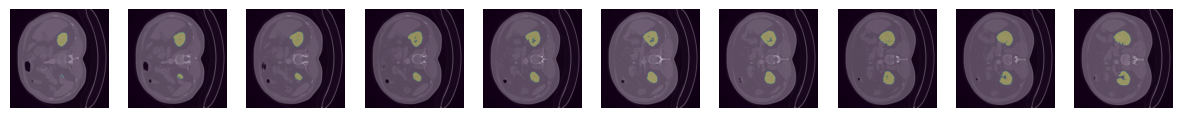

In [7]:
train_points[45].show(axis=2, first_frame=251, frames=10, segmentation_overlap=True)
#Alternatively:
#train_points[45].tio_subject.plot() or....
#train_df.loc[train_df['Case'] == '00045']['Object Address'].*whatever you want to plot with.*

Up to this point, there is now a dataframe for both test and train. Each dataframe contains references to the respective SegmentObject instances.
Now, transformations will be defined, and dataloader made. Note that the subject object also holds the case ID.

In [12]:
""" 
Here the transforms should be defined, and passed as an argument when requesting the dataset.
"""

general_transforms = tio.Compose([
    tio.ToCanonical(),
])

transforms_train = tio.Compose([
    general_transforms,
    tio.RandomFlip(
        axes=(0, 1, 2),
        flip_probability=0.5
    ),
    tio.RandomAffine(
        scales=(0.9, 1.2),
        degrees=15,
    ),
    tio.RandomNoise(
        mean=0,
        std=0.2
    ),
])
#Get tio dataset loops through the dataframe, grabs the tio_subject objects from the object stored in frame, 
# and finally puts them in a dataset.
train_dataset = get_tio_dataset(train_df, transforms=transforms_train)
test_dataset = get_tio_dataset(test_df, transforms=general_transforms)

#These datasets are fully compatible with torchs DataLoader if necacarry.
#torch io transforms only apply things to mask if it is appropriate.
#There are tons of stuff: https://torchio.readthedocs.io/transforms/transforms.html

In [13]:
print(type(train_dataset[0]))

<class 'torchio.data.subject.Subject'>


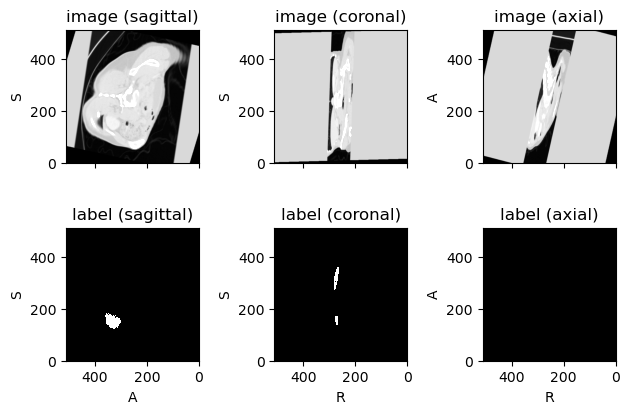

00001


In [14]:
train_dataset[233].plot()
print(train_dataset[0].case)

In [ ]:
batch_size = 2
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)